# Part 1: Introduction

Singapore Mass Rapid Transit (MRT) is one of the essential modes of transportation for many residents and tourists. With 119 stations in operation as of August 2019 and more than 60 stations under construction, the Singapore MRT system network is spanning across the island nation, forming the backbone of the public transport system in Singapore.

Most of the MRT stations in Singapore are strategically built according to the nation's masterplan for transportation, which will eventually support the growth and development of Singapore as a world class city. Many of the stations are integrated with other public transport services, such as the bus interchanges/terminals or Light Rail Transit (LRT), residential areas, business districts, shopping malls etc. As such, each MRT station can be regarded as a small neighbourhood, and existence of the MRT stations will gradually shape the uniqueness of the community around it.

For this project, **we will be looking at the neighbourhoods surrounding the MRT stations and classify them accordingly using the data obtaining via Foursquare**. This analysis will be useful for city planner to get an insight of each of the neighbourhood shaped by the MRT stations (uniqueness quality that can be used to promote tourism), identify gaps or areas of improvement (lack of certain amenities compares to other neighbourhoods), and future expansion possibilities (line extension or new bus interchange etc.).

# Part 2: Data

Several data sources will be used for this project but not limited to:

1. List of MRT stations (considering those currently in-operation as of 2019) - [Wikipedia](https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations)
2. Explore venue types around each station - Foursquare


# Part 3: Scrapping data from Wikipedia

### Importing the libraries & define functions

In [0]:
from bs4 import BeautifulSoup
import json # library to handle JSON files
import numpy as np
import pandas as pd
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import urllib
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge geopy --yes # uncomment this line if needed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if needed
import folium # map rendering library

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

In [0]:
def getgeo(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude];

### Using BeautySoup 4 to scrap the list of MRT stations from Wikipedia and getting the Latitude and Longitude of the MRT stations

In [0]:
url='https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations'
response = urllib.request.urlopen(url)
rawhtml = response.read()
soup = BeautifulSoup(rawhtml, 'html.parser')

In [4]:
#initialize variables... although not really neccessary here
pclist = []
stn_code = ""
stn_shrName = ""
stn_name = ""
NSL =""
EWL =""
NEL =""
CCL =""
DTL =""
CGX =""
Inter = 0
line_color = ""

for table_row in soup.select("table.wikitable tr"):
    cells = table_row.findAll('td')
    if len(cells) == 10:
        stn_code = cells[0].text.strip()
        stn_code = stn_code.replace("\xa0\xa0", ", ")
        stn_code = stn_code.replace("\xa0", "") #spcial case for Tanah Merah Station, interchange to Changi Airport Extension.
        
        if stn_code != "N/A": #include only those stations currently in-operation
                if stn_code.__contains__('NS'):
                    NSL = 1
                    line_color = "red"
                else:
                    NSL = 0

                if stn_code.__contains__('EW'):
                    EWL = 1
                    line_color = "green"
                else:
                    EWL = 0

                if stn_code.__contains__('NE'):
                    NEL = 1
                    line_color = "purple"
                else:
                    NEL = 0

                if stn_code.__contains__('CC'):
                    CCL = 1
                    line_color = "orange"
                else:
                    CCL = 0

                if stn_code.__contains__('DT'):
                    DTL = 1
                    line_color = "blue"
                else:
                    DTL = 0

                if stn_code.__contains__('CG'):
                    CGX = 1
                    line_color = "green"
                else:
                    CGX = 0

                Inter = NSL + EWL + CGX + NEL + CCL + DTL
                if(Inter > 1):
                    line_color = "black"

                stn_shrName = cells[7].text.strip()
                stn_name = cells[2].text.strip()
                geo_name = stn_name + " Station Singapore"
                LatLong = getgeo(geo_name)
                

                pclist.append([stn_shrName,stn_name,stn_code, NSL, EWL, NEL, CGX, CCL, DTL, Inter, LatLong[0], LatLong[1],line_color])
        
            
MRT_df = pd.DataFrame(pclist, columns=["Station Abbr.", "Station Name", "Station Code", "NSL", "EWL", "NEL", "CGX", "CCL", "DTL", "Overlapped", "Lat", "Long", "Color"])
MRT_df.drop_duplicates(subset ="Station Abbr.", keep = "first", inplace = True)
MRT_df = MRT_df.sort_values(by=['Lat'])#.reset_index()
print("The shape of the DataFrame is : ", MRT_df.shape)
MRT_df.head(10)

The shape of the DataFrame is :  (119, 13)


,Station Abbr.,Station Name,Station Code,NSL,EWL,NEL,CGX,CCL,DTL,Overlapped,Lat,Long,Color
61,HBF,HarbourFront,"NE1, CC29",0,0,1,0,1,0,2,1.266055,103.819935,black
102,LBD,Labrador Park,CC27,0,0,0,0,1,0,1,1.266151,103.802741,orange
103,TLB,Telok Blangah,CC28,0,0,0,0,1,0,1,1.270839,103.808725,orange
25,MSP,Marina South Pier,NS28,1,0,0,0,0,0,1,1.270903,103.863195,red
101,PPJ,Pasir Panjang,CC26,0,0,0,0,1,0,1,1.275851,103.792596,orange
40,TPG,Tanjong Pagar,EW15,0,1,0,0,0,0,1,1.276419,103.842929,green
24,MRB,Marina Bay,"NS27, CE2",1,0,0,0,0,0,1,1.277731,103.855259,red
122,DTN,Downtown,DT17,0,0,0,0,0,1,1,1.279274,103.852808,blue
41,OTP,Outram Park,"EW16, NE3",0,1,1,0,0,0,2,1.280276,103.840300,black
105,BFT,Bayfront,"CE1, DT16",0,0,0,0,0,1,1,1.281808,103.861016,blue


#### Some notations

NSL = North South Line (red)

EWL = East West Line (green)

NEL = North East Line (purple)

CCL = Circle Line (orange)

DTL = Downtown Line (blue)

CGX = Changi Airport Extension (green)


### Finding the geographic center of Singapore and determine its Latitude & Longitude

In [5]:
address = 'HSBC Treetop walk' # Map geographic center of Singapore

geolocator= Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

1.3612681 103.8103835


In [8]:
MRT_map = folium.Map(location=[latitude, longitude], zoom_start=12, width=1300, height = 700, tiles="cartodbpositron", no_wrap = True )
MRT_map

### Adding MRT stations onto Singapore Map we created earlier

In [9]:
# add MRT markers to map
for lat, lng, stn_name, stn_code, line_color in zip(MRT_df['Lat'], MRT_df['Long'], MRT_df['Station Name'], MRT_df['Station Code'],MRT_df['Color']):
    label = '{}, {}'.format(stn_code, stn_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=line_color,
        fill=True,
        fill_color=line_color,#'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(MRT_map)  
    
MRT_map

# Part 4: Getting Data from Foursquare API

### Defining Foursquare API

In [0]:
# Define Foursquare API 1st ACC

CLIENT_ID = 'XFX4XQOLNTCT1F5QVLZVCAF35Y45ICRJFQJW0WENTLEXH0BM' # your Foursquare ID
CLIENT_SECRET = 'ZTMLGYGYSVPRE3M3MMIAZXM1X422PWXYCS30ZGHYG0VPB3VA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [0]:
# Define Foursquare API 2nd ACC

CLIENT_ID = 'GVWIRO4IVCSVB2M0HTLADKELCJOMULM04KKGN2MLV2LIPB31' # your Foursquare ID
CLIENT_SECRET = 'WQKBGQ0MR1OZUB5FAZ0OZHA0LQDIDOSTTFV1WMVSCW4ZW33J' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Determine the catergories accepted by Foursquare

In [0]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

#### There are 10 catergories available

In [16]:
len(results['response']['categories'])

10

In [17]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


### Define a function to lookup the count of each category at each MRT station with radius = 1km

In [0]:
def get_venues_count(lat, long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [0]:
#Create new dataframe to store venues data
stations_venues_df = MRT_df.copy()
stations_venues_df = stations_venues_df.reset_index(drop=True)
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [0]:
stations_venues_df.head()

#### Split query into two parts due to free account limitations

In [0]:
# part 1

i = 0
#Request number of venues, store result as CSV
while i < 61:
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Lat.iloc[i], stations_venues_df.Long.iloc[i],radius=1000, categoryId=c[1])
    i = i + 1

In [0]:
# part 2

i = 60
#Request number of venues, store result as CSV
while i < 119:
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Lat.iloc[i], stations_venues_df.Long.iloc[i],radius=1000, categoryId=c[1])
    i = i + 1

In [0]:
# check the data populated
stations_venues_df.head()

# Part 5: Data Exploration

### Import libraries

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Initial assessment of the data

In [0]:
# create a subset

sub_stations_venues = stations_venues_df.iloc[:,[1,10, 11,13,14,15,16,17,18,19,20,21,22]]
sub_stations_venues.head()

,Station Name,Lat,Long,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,HarbourFront,1.266055,103.819935,16,10,1,119,33,35,71,13,120,66
1,Labrador Park,1.266151,103.802741,6,3,0,54,5,20,45,4,13,18
2,Telok Blangah,1.270839,103.808725,15,10,0,39,8,38,68,20,25,29
3,Marina South Pier,1.270903,103.863195,3,1,1,7,4,2,10,0,13,18
4,Pasir Panjang,1.275851,103.792596,0,7,0,58,11,15,83,8,22,17
5,Tanjong Pagar,1.276419,103.842929,45,52,4,183,117,93,190,51,111,95
6,Marina Bay,1.277731,103.855259,23,34,4,136,54,85,158,12,115,54
7,Downtown,1.279274,103.852808,32,49,8,192,83,104,203,17,110,68
8,Outram Park,1.280276,103.840300,39,53,4,216,121,86,175,60,128,115
9,Bayfront,1.281808,103.861016,32,5,4,120,55,74,87,6,82,49


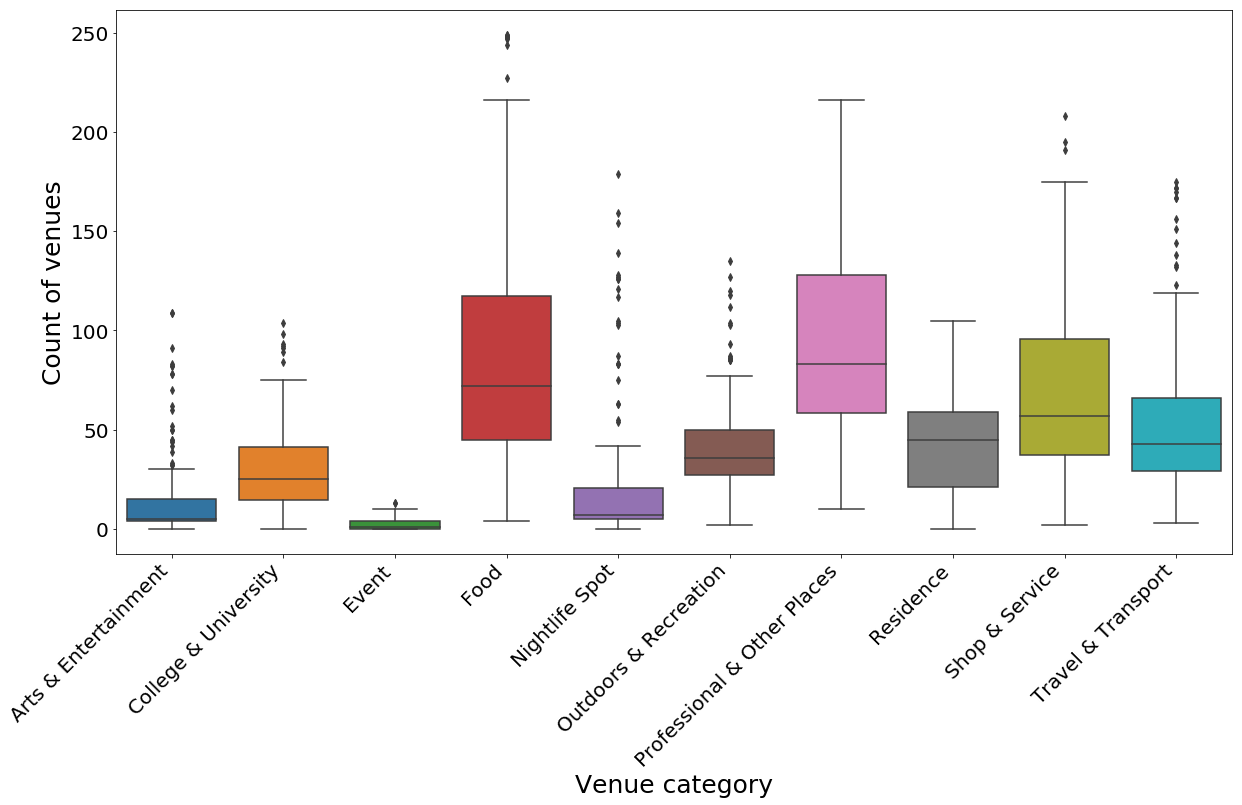

In [0]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot
#dataframe[dataframe.columns[-3:]]
ax = sns.boxplot(data = sub_stations_venues.iloc[:,3:13])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

### Standardize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler

X = sub_stations_venues.values[:,3:]
cluster_dataset = MinMaxScaler().fit_transform(X)
#cluster_dataset

In [0]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.146789,0.096154,0.076923,0.469388,0.184358,0.248120,0.296117,0.123810,0.572816,0.366279
1,0.055046,0.028846,0.000000,0.204082,0.027933,0.135338,0.169903,0.038095,0.053398,0.087209
2,0.137615,0.096154,0.000000,0.142857,0.044693,0.270677,0.281553,0.190476,0.111650,0.151163
3,0.027523,0.009615,0.076923,0.012245,0.022346,0.000000,0.000000,0.000000,0.053398,0.087209
4,0.000000,0.067308,0.000000,0.220408,0.061453,0.097744,0.354369,0.076190,0.097087,0.081395


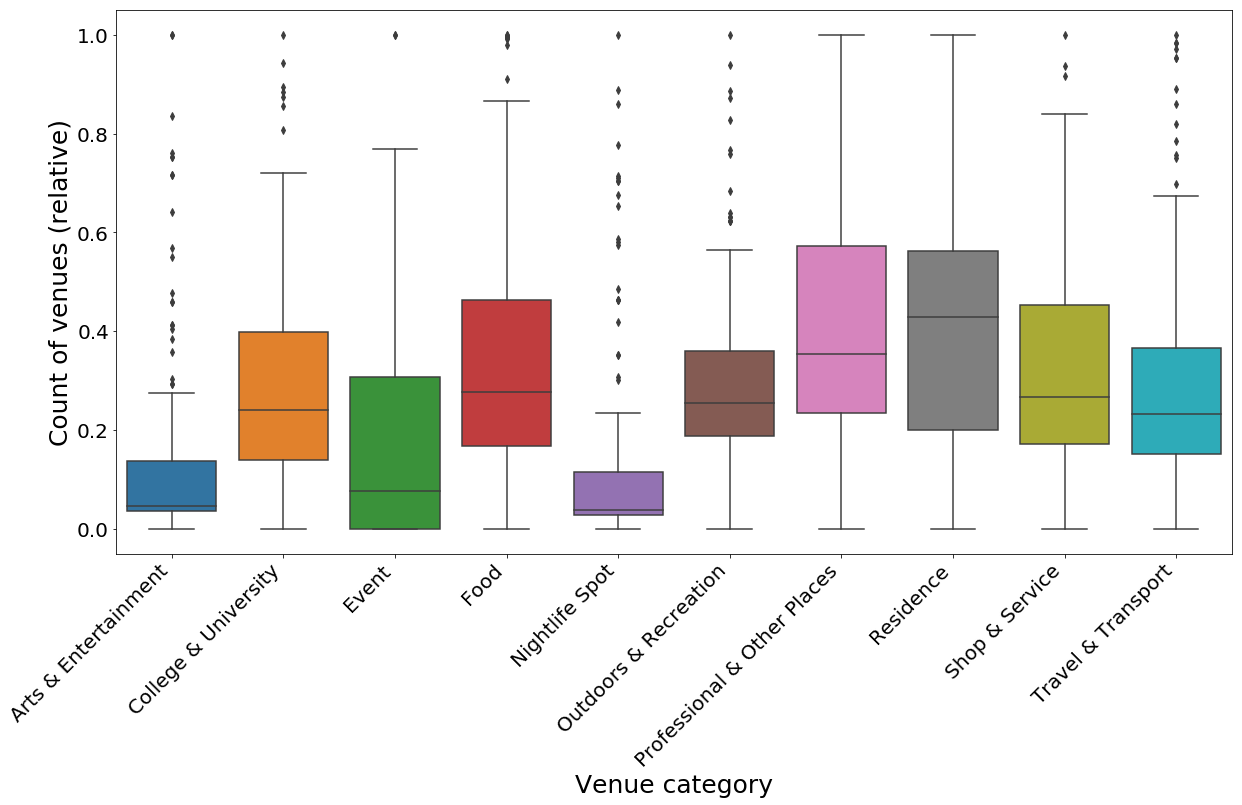

In [0]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()


### Determining optimal number of cluster

In [0]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_df)
    Sum_of_squared_distances.append(km.inertia_)

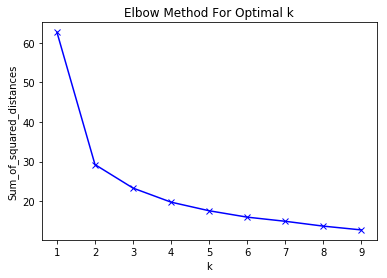

In [0]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### We select k=3 as beyond than any additional cluster will be very similar

# Part 6: Categorical Clustering

In [0]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_


In [0]:
# Check the size to ensure all 119 stations are labeled
kmeans_labels.size

119

In [0]:
# add clustering labels
sub_stations_venues.insert(0, 'Cluster Labels', kmeans_labels)
sub_stations_venues.head()

,Cluster Labels,Station Name,Lat,Long,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0,HarbourFront,1.266055,103.819935,16,10,1,119,33,35,71,13,120,66
1,2,Labrador Park,1.266151,103.802741,6,3,0,54,5,20,45,4,13,18
2,2,Telok Blangah,1.270839,103.808725,15,10,0,39,8,38,68,20,25,29
3,2,Marina South Pier,1.270903,103.863195,3,1,1,7,4,2,10,0,13,18
4,2,Pasir Panjang,1.275851,103.792596,0,7,0,58,11,15,83,8,22,17


In [0]:
#cluster_df.drop(axis=0,'Cluster Labels')
cluster_df.insert(0, 'Cluster Labels', kmeans_labels)
cluster_df.head()

,Cluster Labels,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0,0.146789,0.096154,0.076923,0.469388,0.184358,0.248120,0.296117,0.123810,0.572816,0.366279
1,2,0.055046,0.028846,0.000000,0.204082,0.027933,0.135338,0.169903,0.038095,0.053398,0.087209
2,2,0.137615,0.096154,0.000000,0.142857,0.044693,0.270677,0.281553,0.190476,0.111650,0.151163
3,2,0.027523,0.009615,0.076923,0.012245,0.022346,0.000000,0.000000,0.000000,0.053398,0.087209
4,2,0.000000,0.067308,0.000000,0.220408,0.061453,0.097744,0.354369,0.076190,0.097087,0.081395


### Examine each cluster

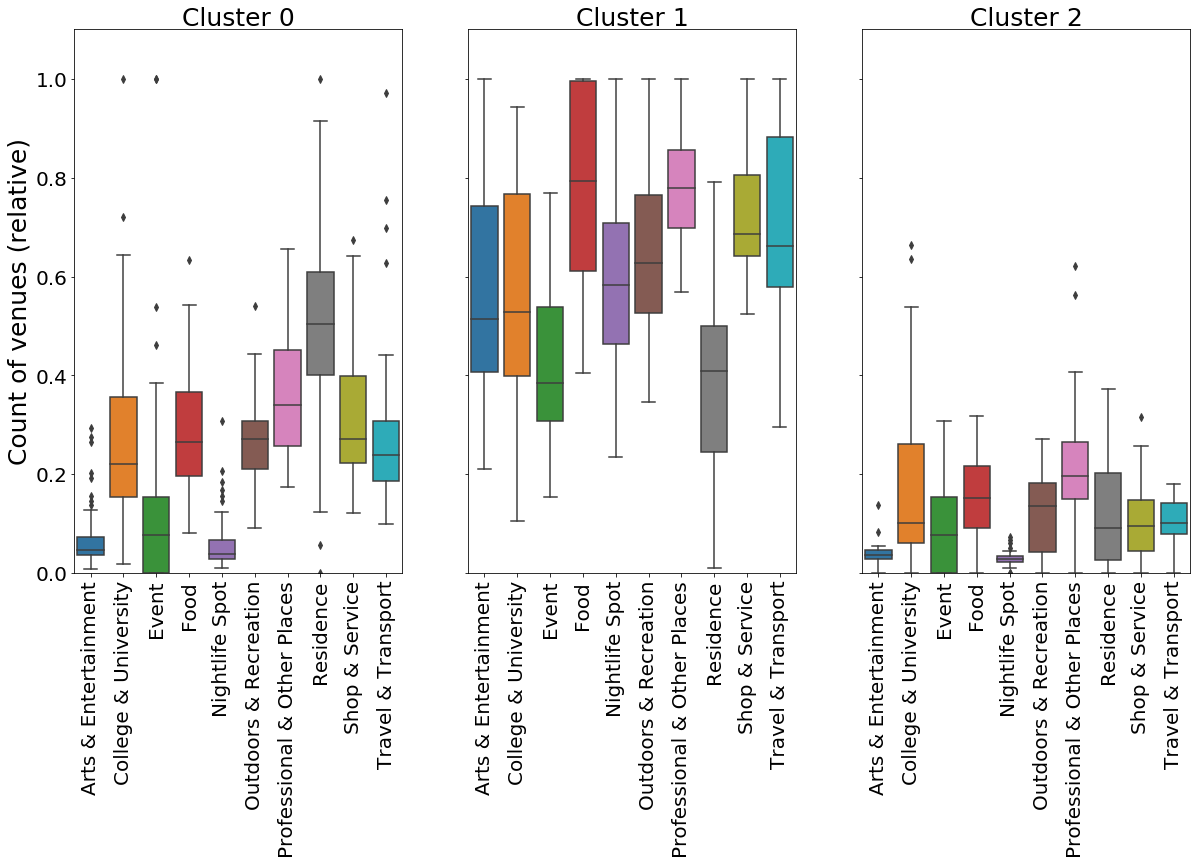

In [0]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = cluster_df[cluster_df['Cluster Labels']==k].drop(['Cluster Labels'], axis=1), ax=axes[k])

plt.show()

### Superimposed the clusters on map

In [0]:
# Create map

# create map
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11,tiles="cartodbpositron")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sub_stations_venues['Lat'], sub_stations_venues['Long'], sub_stations_venues['Station Name'], sub_stations_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters2)
       
map_clusters2

# Part 7: Result

Here is how we can characterize the clusters by looking at venue scores:
Cluster 0 (Blue) has consistently high scores for all venue categories. This is the most diversely developed part of the city
Cluster 1 (Green) has highest marks for Professional & Other Places. This is the business part of the city.
Cluster 2 (Orange) has lower marks with best scores in Profiessional, Residence and Shop & Service.
Cluster 3 (Red) has low marks across the board. These appear to be underdeveloped areas.
Plotting the clusters on a map shows us that:
Cluster 0 is the oldest central part of the city
Cluster 1 is also downtown. Most of these stations are inside or near the Circle Line and have excellent transit accessibility.
Clusters 2 and 3 aren’t so clearly geographically distributed. Cluster 3 areas tend to be at the outskirts but some are more centrally located.
Some stations were classified as Cluster 3 despite being more centrally and accessibly located. This could be a legacy of the “Rust Belt” of closed and abandoned factories. Many stations of the recently opened Moscow Central Circle railway fall into this category. These are prime areas for business and residential development.

# Part 8: Discussion

To be fair, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food and Shop & Service categories. Data doesn’t take into account a venue’s size (e.g. a university building attracts a lot more people that a hot dog stand — each of them is still one Foursquare “venue”).

# Part 9: Conclusion

Foursquare data is limited but can provide insights into a city’s development. This data could be combined with other sources (e.g. city data on number of residents) to provide more accurate results.

# The End